# Oranges
Dataset obtained from https://www.kaggle.com/datasets/shruthiiiee/orange-quality

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing

import matplotlib.pyplot as plt
%matplotlib inline

from itertools import combinations

import numpy.typing as npt
from typing import Final

In [2]:
orangesDF: pd.DataFrame = pd.read_csv("oranges.csv")

In [3]:
orangesDF.head()

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Color,Variety,Blemishes (Y/N),Quality (1-5)
0,7.5,180,12.0,3.2,2.0,10,4.0,Orange,Valencia,N,4.0
1,8.2,220,10.5,3.4,3.0,14,4.5,Deep Orange,Navel,N,4.5
2,6.8,150,14.0,3.0,1.0,7,5.0,Light Orange,Cara Cara,N,5.0
3,9.0,250,8.5,3.8,4.0,21,3.5,Orange-Red,Blood Orange,N,3.5
4,8.5,210,11.5,3.3,2.5,12,5.0,Orange,Hamlin,Y (Minor),4.5


In [4]:
# Establish target and features columns

TARGET_COLUMN_NAME: Final[str] = "Ripeness (1-5)"

OMIT_COLUMNS: Final[list[str]] = [TARGET_COLUMN_NAME, "Quality (1-5)"]
features: list[str] = [columnName for columnName in orangesDF.columns if columnName not in OMIT_COLUMNS]

In [5]:
# Encode colors and varieties using LabelEncoder

orangesDF["Color"] = preprocessing.LabelEncoder().fit(["Yellow-Orange", "Light Orange", "Orange", "Deep Orange", "Orange-Red"]).transform(orangesDF["Color"])
orangesDF["Variety"] = preprocessing.LabelEncoder().fit(orangesDF["Variety"].unique()).transform(orangesDF["Variety"])
orangesDF["Blemishes (Y/N)"] = preprocessing.LabelEncoder().fit(orangesDF["Blemishes (Y/N)"].unique()).transform(orangesDF["Blemishes (Y/N)"])

In [6]:
orangesDF.head()

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Color,Variety,Blemishes (Y/N),Quality (1-5)
0,7.5,180,12.0,3.2,2.0,10,4.0,2,22,0,4.0
1,8.2,220,10.5,3.4,3.0,14,4.5,0,13,0,4.5
2,6.8,150,14.0,3.0,1.0,7,5.0,1,3,0,5.0
3,9.0,250,8.5,3.8,4.0,21,3.5,3,1,0,3.5
4,8.5,210,11.5,3.3,2.5,12,5.0,2,6,6,4.5


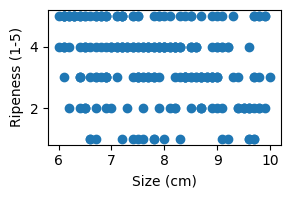

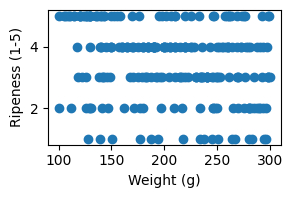

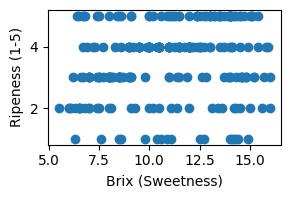

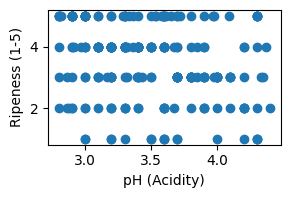

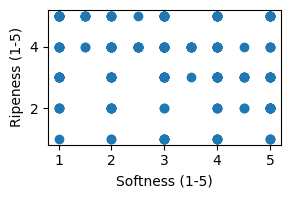

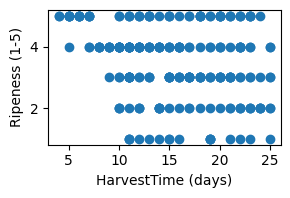

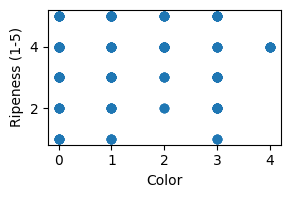

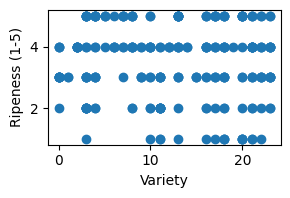

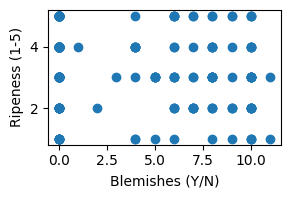

In [7]:
for thisFeature in features:
    thisFeatureColumn : "pd.Series[float]" = orangesDF[thisFeature].astype(float)
    plt.figure(figsize=(3, 1.75))
    plt.scatter(thisFeatureColumn, orangesDF[TARGET_COLUMN_NAME].astype(int))
    plt.xlabel(thisFeature)
    plt.ylabel(TARGET_COLUMN_NAME)
    plt.show()
    plt.close()

    histDF: pd.DataFrame = orangesDF[[TARGET_COLUMN_NAME, thisFeature]]

    if thisFeatureColumn.dtype.name == "category":
        histDF[thisFeature] = histDF[thisFeature].astype(int)
        histDF.hist()
        plt.xlabel(TARGET_COLUMN_NAME)
        plt.ylabel(thisFeature)
    if thisFeatureColumn.dtype.name == "category":
        histDF[thisFeature] = histDF[thisFeature].astype(int)
        histDF.hist()
        plt.xlabel(thisFeature)
        plt.ylabel(TARGET_COLUMN_NAME)
    plt.show()
    plt.close()

In [8]:
# Normalize the dataset; restore column headers after

dfColumns = orangesDF.columns
orangesDF = pd.DataFrame(preprocessing.StandardScaler().fit(orangesDF).transform(orangesDF))
orangesDF.columns = dfColumns

In [9]:
orangesDF.head()

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Color,Variety,Blemishes (Y/N),Quality (1-5)
0,-0.318168,-0.445988,0.396454,-0.651937,-0.812044,-1.005949,0.332927,0.470591,1.348849,-0.733707,0.180354
1,0.327740,0.263940,-0.148068,-0.175898,-0.054974,-0.253049,0.748654,-1.138097,0.092125,-0.733707,0.674277
2,-0.964075,-0.978434,1.122482,-1.127977,-1.569115,-1.570623,1.164382,-0.333753,-1.304235,-0.733707,1.168200
3,1.065920,0.796386,-0.874096,0.776182,0.702096,1.064525,-0.082800,1.274935,-1.583508,-0.733707,-0.313569
4,0.604557,0.086458,0.214947,-0.413918,-0.433509,-0.629499,1.164382,0.470591,-0.885327,0.812853,0.674277


In [10]:
# Determine features (will test every possible combination) and target series

orangesDF = orangesDF.sort_values(TARGET_COLUMN_NAME, ascending=True)
TARGET_SERIES: Final["pd.Series[float]"] = orangesDF[TARGET_COLUMN_NAME].astype(str)

featureCombinations: list[list[str]] = []
for thisCombinationList in [list(combinations(features, featureCount)) for featureCount in range(1, len(features) + 1)]:
    featureCombinations.extend([list(thisCombination) for thisCombination in thisCombinationList])

In [11]:
NEIGHBOR_COUNT_MIN: Final[int] = 1
NEIGHBOR_COUNT_MAX: Final[int] = 35

def trainModel(features: list[str]) -> tuple[KNeighborsClassifier, int, np.longdouble]:
    """Train a KNN model to predict values of TARGET_SERIES using the given features.

    Tests every possible K from NEIGHBOR_COUNT_MIN to NEIGHBOR_COUNT_MAX, inclusive.
    Returns a tuple containing the best model, the K used to obtain that model,
    and its accuracy from sklearn.metrics.accuracy_score (0.0 to 1.0, inclusive).
    """

    featureDF: pd.DataFrame = orangesDF[features].astype(float)

    trainX: pd.DataFrame
    testX: pd.DataFrame
    trainY: pd.DataFrame
    testY: pd.DataFrame
    trainX, testX, trainY, testY = train_test_split(featureDF, TARGET_SERIES)

    models: list[KNeighborsClassifier] = []
    modelAccuracies: npt.NDArray[np.longdouble] = np.zeros(NEIGHBOR_COUNT_MAX - NEIGHBOR_COUNT_MIN + 1, np.longdouble)

    for thisNeighborCount in range(NEIGHBOR_COUNT_MIN, NEIGHBOR_COUNT_MAX + 1):
        thisModel = KNeighborsClassifier(thisNeighborCount, n_jobs=-1, weights="distance").fit(trainX, trainY)
        models.append(thisModel)
        modelAccuracies[thisNeighborCount - NEIGHBOR_COUNT_MIN] = np.longdouble(metrics.accuracy_score(testY, thisModel.predict(testX)))
    
    bestModelIndex: int = int(modelAccuracies.argmax())
    bestModel: KNeighborsClassifier = models[bestModelIndex]
    return (bestModel, bestModelIndex + NEIGHBOR_COUNT_MIN, modelAccuracies[bestModelIndex])

In [12]:
# Enumerate through and train with all combinations of features, adding each model to allModels
# (and each model's accuracy to allModelAccuracies)

allModels: list[tuple[list[str], KNeighborsClassifier, int]] = []
allModelAccuracies: npt.NDArray[np.longdouble] = np.zeros(len(featureCombinations), np.longdouble)

for thisFeatureCombinationIndex, thisFeatureCombination in enumerate(featureCombinations):
    model: KNeighborsClassifier
    neighborCount: int
    accuracy: np.longdouble
    model, neighborCount, accuracy = trainModel(thisFeatureCombination)
    allModels.append((thisFeatureCombination, model, neighborCount))
    allModelAccuracies[thisFeatureCombinationIndex] = accuracy

In [13]:
# Determine the best possible combination of features for predicting TARGET_SERIES
# by finding the maximum of the combinations' highest achievable accuracies

highestAccuracy: np.longdouble = allModelAccuracies.max()
finalBestModelIndices: list[int] = np.argwhere(allModelAccuracies == highestAccuracy).flatten().tolist()

In [14]:
def printModelInfo(modelIndex: int) -> None:
    """Print info for a model, given its index in allModels."""
    modelInfo: tuple[list[str], KNeighborsClassifier, int] = allModels[modelIndex]
    modelFeatures: list[str] = modelInfo[0]
    modelNeighborCount: int = modelInfo[2]
    modelAccuracy: np.longdouble = allModelAccuracies[modelIndex]

    print(f"Features: {modelFeatures[0]}", end="")
    for thisFeature in modelFeatures[1:]:
        print(", " + thisFeature, end="")
    print()

    print(f"\tK: {modelNeighborCount}")
    print(f"\tAccuracy: ~{modelAccuracy}")

print("Most accurate model(s):", end="\n\n")

for thisModelIndex in finalBestModelIndices:
    printModelInfo(thisModelIndex)

Most accurate model(s):

Features: Size (cm), Brix (Sweetness), HarvestTime (days), Color
	K: 5
	Accuracy: ~0.5737704918032787
Features: Brix (Sweetness), pH (Acidity), Softness (1-5), Color, Blemishes (Y/N)
	K: 7
	Accuracy: ~0.5737704918032787
Features: Size (cm), Brix (Sweetness), pH (Acidity), Softness (1-5), Color, Variety, Blemishes (Y/N)
	K: 3
	Accuracy: ~0.5737704918032787


In [15]:
# Create a DataFrame to represent all feature combinations and their corresponding highest accuracies
# (to explore the models a bit more, as below)

modelDict: dict[str, list[np.longdouble | int | list[str]]] = {"Features": [modelInfo[0] for modelInfo in allModels],
                                                               "K": [modelInfo[2] for modelInfo in allModels],
                                                               "Accuracy": [thisAccuracy for thisAccuracy in allModelAccuracies]}

modelDF: pd.DataFrame = pd.DataFrame(modelDict).set_index("Features").sort_values("Accuracy", ascending=False)

In [16]:
print("20 best models:")
modelDF[:20]

20 best models:


,K,Accuracy
Features,,
"[Size (cm), Brix (Sweetness), HarvestTime (days), Color]",5,0.573770
"[Brix (Sweetness), pH (Acidity), Softness (1-5), Color, Blemishes (Y/N)]",7,0.573770
"[Size (cm), Brix (Sweetness), pH (Acidity), Softness (1-5), Color, Variety, Blemishes (Y/N)]",3,0.573770
"[Brix (Sweetness), pH (Acidity), Color, Variety]",6,0.557377
"[Size (cm), Brix (Sweetness), pH (Acidity), HarvestTime (days), Color]",29,0.540984
"[pH (Acidity), Softness (1-5), HarvestTime (days), Color, Variety, Blemishes (Y/N)]",8,0.540984
"[Size (cm), Softness (1-5), HarvestTime (days), Color, Variety, Blemishes (Y/N)]",12,0.540984
"[Brix (Sweetness), pH (Acidity), Color]",3,0.540984
"[Brix (Sweetness), pH (Acidity), Softness (1-5), Color, Variety]",5,0.540984


In [17]:
print("20 worst models:")
modelDF[-20:]

20 worst models:


,K,Accuracy
Features,,
"[Size (cm), Variety, Blemishes (Y/N)]",29,0.295082
"[Softness (1-5), Color, Blemishes (Y/N)]",4,0.295082
"[Size (cm), HarvestTime (days), Variety]",3,0.295082
"[Variety, Blemishes (Y/N)]",4,0.295082
[Size (cm)],4,0.278689
"[Size (cm), Softness (1-5)]",1,0.278689
"[pH (Acidity), Softness (1-5), Variety]",1,0.278689
"[Size (cm), Weight (g), Brix (Sweetness), pH (Acidity), HarvestTime (days)]",12,0.278689
"[Weight (g), HarvestTime (days)]",10,0.262295
